In [ ]:
!pip install tensorflow-privacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.24.0
    Uninstalling tensorflow-probability-0.24.0:
      Successfully uninstalled tensorflow-probability-0.24.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf


import warnings
warnings.filterwarnings("ignore")

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding,Conv1D
from tensorflow.keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from keras.regularizers import l2
import scipy.stats
import tarfile
from pandas.errors import EmptyDataError
import time
import os
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
import tensorflow_privacy as tfp

In [ ]:
df=pd.read_csv('IoT_camera.csv')
df=df.iloc[:,2:]
df

,L4_tcp,L4_udp,L7_http,L7_https,port_class_src,port_class_dst,pck_size,ip_dst_new,ethernet_frame_size,ttl,...,average,skew_e,kurt_e,var_e,q3_e,q1_e,iqr_e,epoch_timestamp,inter_arrival_time,time_since_previously_displayed_frame
0,0,1,0,0,3,2,1388,2385310024,1422,64,...,1185.894737,-1.876388,1.520833,217848.199446,1388.0,1388.00,0.00,1.633542e+09,0.000625,10.335814
1,0,1,0,0,3,2,1388,2385310024,1422,64,...,1228.000000,-2.267787,3.142857,179200.000000,1388.0,1388.00,0.00,1.633542e+09,0.005834,14.333014
2,0,1,0,0,3,2,1388,2385310024,1422,64,...,1174.666667,-1.788854,1.200000,227555.555556,1388.0,1388.00,0.00,1.633542e+09,0.000000,13.044197
3,0,1,0,0,3,2,1388,2385310024,1422,64,...,1320.631579,-4.006938,14.055556,81693.074792,1388.0,1388.00,0.00,1.633542e+09,0.000883,2.659452
4,0,1,0,0,3,2,1388,2385310024,1422,64,...,748.000000,0.000000,-2.000000,409600.000000,1388.0,108.00,1280.00,1.633542e+09,0.000603,8.510484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153932,0,1,0,0,2,3,60,3232270721,94,47,...,780.611111,-0.825583,-1.165924,192593.015432,1096.0,408.00,688.00,1.634046e+09,0.017099,27.400710
153933,0,1,0,0,2,3,60,3232270721,94,46,...,618.750000,-0.101472,-1.801175,215640.062500,1096.0,60.00,1036.00,1.634046e+09,0.000056,29.139172
153934,0,1,0,0,3,2,1096,2211110130,1130,64,...,1096.000000,0.000000,-3.000000,0.000000,1096.0,1096.00,0.00,1.634046e+09,0.000000,11.267276
153935,0,1,0,0,3,2,1116,2211110130,1150,64,...,1097.818182,2.846050,6.100000,33.057851,1096.0,1096.00,0.00,1.634046e+09,0.000000,12.436347


In [ ]:
df.columns

Index(['L4_tcp', 'L4_udp', 'L7_http', 'L7_https', 'port_class_src',
       'port_class_dst', 'pck_size', 'ip_dst_new', 'ethernet_frame_size ',
       'ttl', 'total_length', 'protocol ', 'source_port', 'dest_port',
       'DNS_count', 'NTP_count', 'ARP_count', 'cnt', 'L3_ip_dst_count',
       'most_freq_d_ip', 'most_freq_prot', 'most_freq_sport',
       'most_freq_dport', 'sum_et', 'min_et', 'max_et', 'med_et', 'average_et',
       'skew_et', 'kurt_et', 'var', 'q3', 'q1', 'iqr', 'sum_e', 'min_e',
       'max_e', 'med', 'average', 'skew_e', 'kurt_e', 'var_e', 'q3_e', 'q1_e',
       'iqr_e', 'epoch_timestamp', 'inter_arrival_time',
       'time_since_previously_displayed_frame'],
      dtype='object')

In [ ]:
corr_cols=['L7_https','most_freq_sport','pck_size','cnt','most_freq_dport','most_freq_prot','min_et', 'max_et','med_et','average_et','q3','q1', 'min_e', 'max_e', 'med', 'average', 'q3_e', 'q1_e' , 'time_since_previously_displayed_frame','port_class_src','port_class_dst','pck_size','total_length','ip_dst_new', 'L4_tcp', 'NTP_count','most_freq_d_ip','sum_e','skew_e', 'iqr','var','iqr_e','L4_udp']
df.drop(columns=corr_cols,axis=1,inplace=True)
df

,L7_http,ethernet_frame_size,ttl,protocol,source_port,dest_port,DNS_count,ARP_count,L3_ip_dst_count,sum_et,skew_et,kurt_et,kurt_e,var_e,epoch_timestamp,inter_arrival_time
0,0,1422,64,17,49789,4500,0,0,7,4266,0.000000,-3.000000,1.520833,217848.199446,1.633542e+09,0.000625
1,0,1422,64,17,49789,4500,0,0,7,14744,-1.839454,1.470684,3.142857,179200.000000,1.633542e+09,0.005834
2,0,1422,64,17,49789,4500,0,0,7,8014,-0.293612,-1.842649,1.200000,227555.555556,1.633542e+09,0.000000
3,0,1422,64,17,49789,4500,0,0,7,4266,0.000000,-3.000000,14.055556,81693.074792,1.633542e+09,0.000883
4,0,1422,64,17,49789,4500,0,0,7,6398,0.223607,-1.950000,-2.000000,409600.000000,1.633542e+09,0.000603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153932,0,94,47,17,11123,59861,0,0,15,4595,-0.685658,-1.502247,-1.165924,192593.015432,1.634046e+09,0.017099
153933,0,94,46,17,11123,59861,0,0,14,716,1.154301,-0.666977,-1.801175,215640.062500,1.634046e+09,0.000056
153934,0,1130,64,17,59861,11123,0,0,15,15820,0.000000,-3.000000,-3.000000,0.000000,1.634046e+09,0.000000
153935,0,1150,64,17,59861,29483,4,0,15,21490,4.006938,14.055556,6.100000,33.057851,1.634046e+09,0.000000


In [ ]:
df['L3_ip_dst_count'].value_counts()

,count
L3_ip_dst_count,
9,28194
15,22859
10,14267
11,13405
6,12641
14,11702
7,9469
2,6754
12,3786


In [ ]:
mms = MinMaxScaler()
numerical_data_rescaled = mms.fit_transform(df)
numerical_data_rescaled
numerical_data_rescaled.shape[1]

16

In [ ]:
def build_generator(n_columns, latent_dim):
    model = Sequential()

    model.add(Dense(16, kernel_initializer = "he_uniform",input_dim=latent_dim))
    model.add(LeakyReLU(0.2))

    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(32,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))

    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))

    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))

    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(256,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))

    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(512,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))

    #model.add(Dense(1024,  kernel_initializer = "he_uniform"))
    #model.add(LeakyReLU(0.2))


    #model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model

In [ ]:
latent_dim = 100
generator = build_generator(numerical_data_rescaled.shape[1], latent_dim)


In [ ]:

l2_norm_clip = 1.0  # Clip gradients to this norm
noise_multiplier = 1.1  # Noise added to gradients
num_microbatches = 1  # Number of microbatches
learning_rate = 0.0002  # Learning rate for the optimizer

# Create a DP optimizer
optimizer = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

In [ ]:
def build_discriminator(inputs_n):
	model = Sequential()



	#model.add(Dense(1024,  kernel_initializer = "he_uniform"))
	#model.add(LeakyReLU(0.2))
	#model.add(Dropout(0.25))
	model.add(Dense(512,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.25))
	model.add(Dense(256,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.25))
	model.add(Dense(128,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.25))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))

	model.add(LeakyReLU(0.2))
	#model.add(BatchNormalization(momentum=0.8))
	model.add(Dropout(0.25))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	#model.add(BatchNormalization(momentum=0.8))
	model.add(Dropout(0.25))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	#model.add(BatchNormalization(momentum=0.8))
	model.add(Dropout(0.25))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

In [ ]:

discriminator = build_discriminator(numerical_data_rescaled.shape[1])
#plot_model(discriminator, show_layer_names = True, show_shapes = True)

In [ ]:
def build_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect generator and dicriminator
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss = "binary_crossentropy", optimizer = optimizer)
	return model

In [ ]:
gan = build_gan(generator, discriminator)


In [ ]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)
    dataset_size=len(data)
    steps_per_epoch = dataset_size // n_batch
    delta=1e-5
    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):

        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]

        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)


        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        # Ensure d_loss_real and d_loss_fake are single numbers by taking the first element if they are lists
        d_loss = 0.5 * np.add(d_loss_real[0] if isinstance(d_loss_real, list) else d_loss_real, d_loss_fake[0] if isinstance(d_loss_fake, list) else d_loss_fake)
        discriminator_loss.append(d_loss)


        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)

        # Ensure g_loss is a single number by taking the first element if it is a list
        generator_loss.append(g_loss[0] if isinstance(g_loss, list) else g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            # Ensure g_loss and d_loss are single numbers before printing
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss[0] if isinstance(g_loss, list) else g_loss, d_loss))


    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 2ms/step
Epoch: 250 [Generator loss: 1.199168] [Discriminator loss: 0.740883]
16/16 [==============================] - 0s 2ms/step
Epoch: 500 [Generator loss: 1.167562] [Discriminator loss: 0.732735]
16/16 [==============================] - 0s 2ms/step
Epoch: 750 [Generator loss: 1.206138] [Discriminator loss: 0.704122]
16/16 [==============================] - 0s 2ms/step
Epoch: 1000 [Generator loss: 1.175019] [Discriminator loss: 0.722420]
16/16 [==============================] - 0s 2ms/step
Epoch: 1250 [Generator loss: 1.263624] [Discriminator loss: 0.715870]
16/16 [==============================] - 0s 2ms/step
Epoch: 1500 [Generator loss: 1.188694] [Discriminator loss: 0.700955]
16/16 [==============================] - 0s 2ms/step
Epoch: 1750 [Generator loss: 1.178919] [Discriminator loss: 0.698171]
16/16 [==============================] - 0s 2ms/step
Epoch: 2000 [Generator loss: 1.173620]

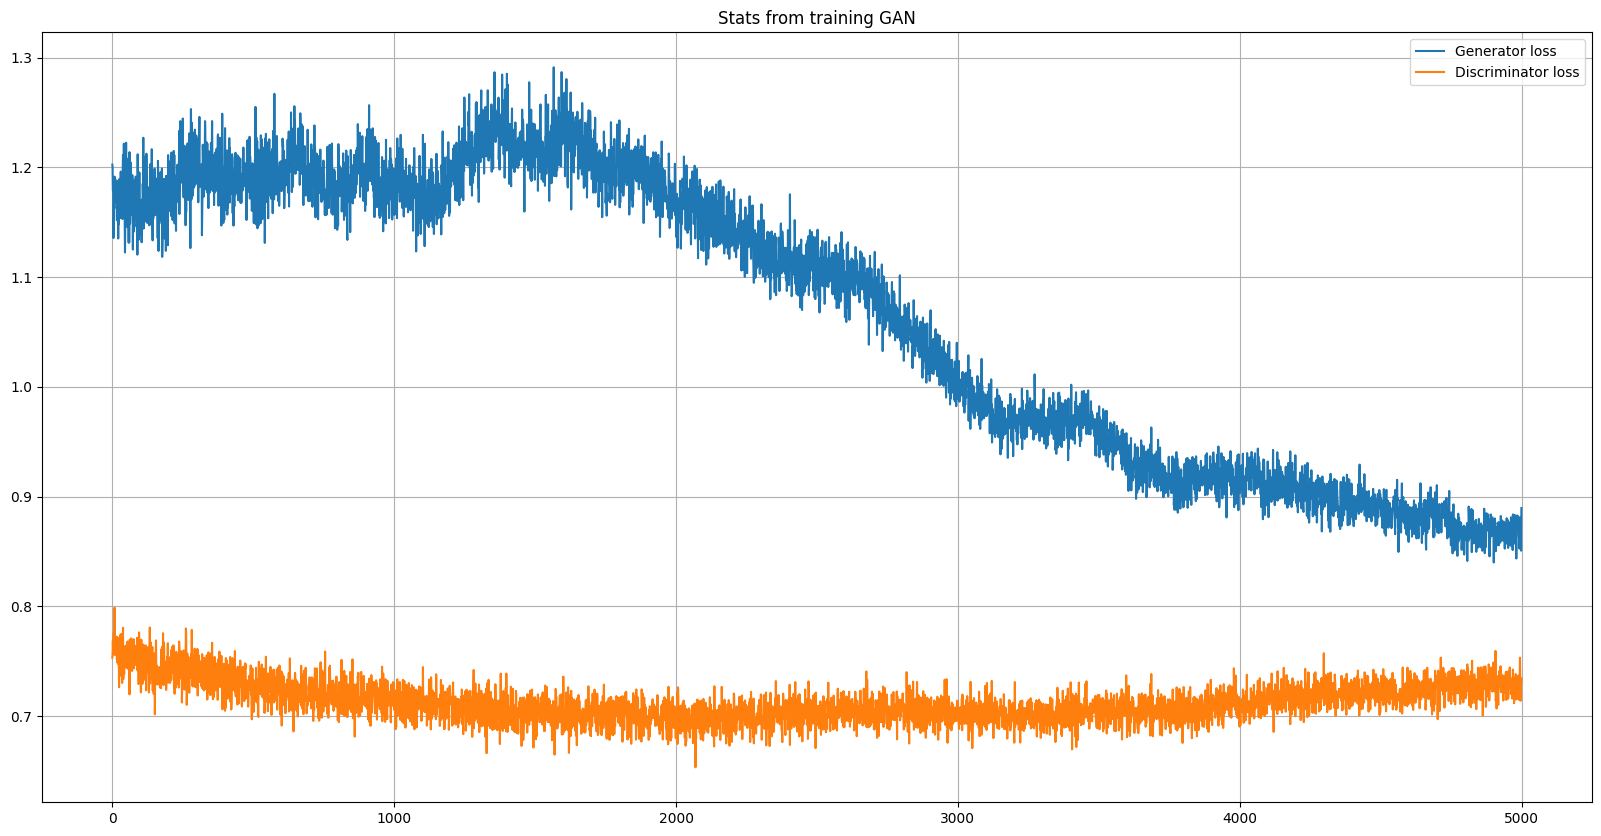

In [ ]:
train(gan, generator, discriminator, numerical_data_rescaled, latent_dim, n_epochs = 5000, n_batch = 1024, n_eval = 250)

In [ ]:
noise = np.random.normal(0, 1, (153937 , latent_dim))
generated_numerical_data = generator.predict(noise)
generated_numerical_data

4811/4811 [==============================] - 9s 2ms/step


array([[0.0512521 , 0.56602067, 0.5326219 , ..., 0.03597788, 0.672705  ,
        0.08923434],
       [0.05032051, 0.29524514, 0.06979396, ..., 0.28170565, 0.8136302 ,
        0.18387233],
       [0.0631003 , 0.22987379, 0.4525679 , ..., 0.36952463, 0.97366005,
        0.01415381],
       ...,
       [0.12842792, 0.07077908, 0.12022007, ..., 0.2472186 , 0.6259441 ,
        0.11269659],
       [0.01351845, 0.52936304, 0.13486262, ..., 0.01776792, 0.77870804,
        0.04015847],
       [0.14928246, 0.0443337 , 0.1459758 , ..., 0.5593308 , 0.23034412,
        0.02629665]], dtype=float32)

In [ ]:
generated_numerical_data = mms.inverse_transform(generated_numerical_data)
gen_df = pd.DataFrame(data = generated_numerical_data.astype(int), columns = df.columns)
gen_df

,L7_http,ethernet_frame_size,ttl,protocol,source_port,dest_port,DNS_count,ARP_count,L3_ip_dst_count,sum_et,skew_et,kurt_et,kurt_e,var_e,epoch_timestamp,inter_arrival_time
0,0,875,135,15,57267,56153,6,2,4,4054,-1,1,-2,18858,1633935744,1
1,0,476,17,13,32584,13404,2,0,11,603,-3,0,-2,147663,1634021504,3
2,0,380,115,10,18337,4097,1,0,9,8387,-2,-2,-2,193695,1634118912,0
3,0,184,26,14,26644,31953,4,0,8,8515,-1,0,0,360565,1633756032,2
4,0,265,201,11,52508,47852,1,0,2,12298,0,0,-2,59932,1633728000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153932,0,1337,24,13,62140,41852,6,0,8,3494,-1,3,0,261994,1633728512,5
153933,0,472,145,15,42668,26467,5,3,4,12601,1,7,-2,118006,1633574016,1
153934,0,146,30,10,36615,18506,3,0,10,15055,-3,3,0,129586,1633907200,2
153935,0,821,34,16,60675,45518,2,1,21,4141,-1,-1,-2,9313,1634000256,0


In [ ]:
gen_df.to_csv('synthetic_IoT_camera.csv')